<a href="https://colab.research.google.com/github/rodrigofardin/Redes-Neurais-Artificiais/blob/main/Classificador_MNIST_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from pathlib import Path
import numpy as np
import struct
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.utils.sidecar_evaluator import optimizer

from prompt_toolkit.shortcuts.progress_bar.base import E

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
class DataLoading(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                test_images_filepath, test_labels_filepath):
      self.training_images_filepath = training_images_filepath
      self.training_labels_filepath = training_labels_filepath
      self.test_images_filepath = test_images_filepath
      self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
      labels = []
      with open(labels_filepath, 'rb') as file:
          _,_ = struct.unpack('>2I',file.read(8))
          labels = bytearray(file.read())        
      with open(images_filepath, 'rb') as file:
          _,size,rows,cols = struct.unpack(">4I", file.read(16))
          image_data = bytearray(file.read())        
      images = []
      for i in range(size):
          images.append([0] * rows * cols)
      for i in range(size):
          img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
          img = img.reshape(28, 28)
          images[i][:] = img            
      
      return images, labels

    def load_data(self):
      x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
      x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
      return (x_train, y_train),(x_test, y_test)

    def prepare_data(self):

      (x_train, y_train), (x_test, y_test) = self.load_data()
      x_train = np.array(x_train).reshape(60000, 28 * 28)
      x_test = np.array(x_test).reshape(10000, 28 * 28)
      x_train = x_train.astype("float32") / 255
      x_test = x_test.astype("float32") / 255
      X_train = pd.DataFrame(x_train)
      X_test = pd.DataFrame(x_test)
      y_train = pd.DataFrame(np.array(y_train).flatten())
      y_test = pd.DataFrame(np.array(y_test).flatten())
      y_train.rename(columns={0:'target'}, inplace =True)
      y_test.rename(columns={0:'target'}, inplace =True)
      return (X_train, y_train), (X_test, y_test)

In [42]:
training_images_filepath = '/content/drive/MyDrive/python/Redes Neurais Artificiais/MNIST/archive/train-images.idx3-ubyte'
training_labels_filepath = '/content/drive/MyDrive/python/Redes Neurais Artificiais/MNIST/archive/train-labels.idx1-ubyte'
test_images_filepath = '/content/drive/MyDrive/python/Redes Neurais Artificiais/MNIST/archive/t10k-images.idx3-ubyte'
test_labels_filepath = '/content/drive/MyDrive/python/Redes Neurais Artificiais/MNIST/archive/t10k-labels.idx1-ubyte'

# load MINST dataset

mnist_dataloader = DataLoading(training_images_filepath, training_labels_filepath,
                               test_images_filepath, test_labels_filepath)
(train_images, train_labels), (test_images, test_labels) = mnist_dataloader.prepare_data()


In [45]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [46]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [44]:
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape)

(((60000, 784), (60000, 1)), ((10000, 784), (10000, 1)))

label: 3



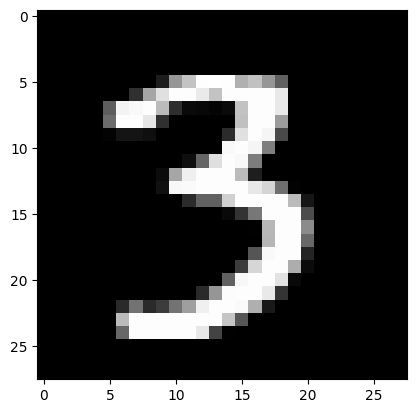

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(number_row):
      (X_train, y_train), (X_test, y_test) = mnist_dataloader.prepare_data()
      combine_X = pd.concat([X_train,X_test])
      combine_y = pd.concat([y_train,y_test])
      print('label: {0}'.format(combine_y.iloc[number_row][0]))
      print()
      plt.imshow(combine_X.iloc[number_row,::].to_numpy().reshape(28,28),cmap = plt.cm.gray)

show_image(10000)

In [47]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 10ms/step - loss: 0.2660 - accuracy: 0.9236
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.1082 - accuracy: 0.9679
Epoch 3/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0705 - accuracy: 0.9789
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0511 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0389 - accuracy: 0.9886


In [48]:
predicted = model.predict(test_images[0:1])
predicted[0]

1/1 [==============================] - 0s 87ms/step


array([5.67130343e-08, 1.41749465e-08, 1.40544416e-05, 3.22316191e-05,
       1.21590599e-10, 1.03967409e-07, 2.10594216e-12, 9.99949455e-01,
       2.92004165e-06, 1.29809337e-06], dtype=float32)

In [49]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 2s 5ms/step - loss: 0.0652 - accuracy: 0.9784
test_acc: 0.9783999919891357


In [53]:
train_labels_hot = to_categorical(train_labels)
test_labels_hot = to_categorical(test_labels)

In [56]:
class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size
  def fit(self, X, y):
    self.model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(y.shape[1], activation="softmax")
    ])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
    return self
  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    return np.array([(a == np.max(a)) for a in probabilities])

modelo = RedeNeural()
modelo.fit(train_images, train_labels_hot)
ypred = modelo.predict(test_images)
accuracy_score(test_labels_hot, ypred)

Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.2628 - accuracy: 0.9242
Epoch 2/5
469/469 [==============================] - 6s 14ms/step - loss: 0.1068 - accuracy: 0.9690
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0705 - accuracy: 0.9792
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0508 - accuracy: 0.9847
Epoch 5/5
313/313 [==============================] - 1s 3ms/step


0.9798

In [57]:
class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(yhot.shape[1], activation="softmax")
    ])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

modelo = RedeNeural()
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 [==============================] - 5s 11ms/step - loss: 0.2627 - accuracy: 0.9245
Epoch 2/5
469/469 [==============================] - 6s 13ms/step - loss: 0.1065 - accuracy: 0.9683
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0702 - accuracy: 0.9792
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0506 - accuracy: 0.9849
Epoch 5/5
313/313 [==============================] - 1s 3ms/step


0.9795

In [58]:
mnist_dataloader = DataLoading(training_images_filepath, training_labels_filepath,
                               test_images_filepath, test_labels_filepath)
(train_images, train_labels), (test_images, test_labels) = mnist_dataloader.prepare_data()

In [60]:
modelo = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("ann", RedeNeural())
])
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 [==============================] - 9s 18ms/step - loss: 0.2633 - accuracy: 0.9242
Epoch 2/5
469/469 [==============================] - 6s 13ms/step - loss: 0.1061 - accuracy: 0.9682
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0698 - accuracy: 0.9789
Epoch 4/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0506 - accuracy: 0.9850
Epoch 5/5
313/313 [==============================] - 1s 3ms/step


0.9802

In [67]:
class DividePor255(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.astype("float32") / 255

from sklearn.pipeline import Pipeline

modelo = Pipeline([
    ("scaler", DividePor255()), 
    ("ann", RedeNeural())
])
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 [==============================] - 8s 14ms/step - loss: 2.2397 - accuracy: 0.2613
Epoch 2/5
469/469 [==============================] - 7s 14ms/step - loss: 1.6853 - accuracy: 0.5942
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 1.0509 - accuracy: 0.7448
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.7542 - accuracy: 0.8100
Epoch 5/5
313/313 [==============================] - 1s 3ms/step


0.8555

In [68]:
mnist_dataloader = DataLoading(training_images_filepath, training_labels_filepath,
                               test_images_filepath, test_labels_filepath)
(train_images, train_labels), (test_images, test_labels) = mnist_dataloader.prepare_data()

In [72]:
class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = keras.Sequential([
        layers.Conv2D(4, 4, activation='relu'),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(yhot.shape[1], activation="softmax")
    ])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

class MudaShape(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  
  def transform(self, X, y=None):
    if isinstance(X, pd.DataFrame):
      X = X.to_numpy()
    X = X.reshape((-1, 28, 28, 1))
    return X

modelo = Pipeline([
    ("scaler", DividePor255()), 
    ("reshape", MudaShape()), 
    ("ann", RedeNeural())
])
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)  

Epoch 1/5
469/469 [==============================] - 35s 72ms/step - loss: 1.4981 - accuracy: 0.5619
Epoch 2/5
469/469 [==============================] - 32s 69ms/step - loss: 0.4051 - accuracy: 0.8832
Epoch 3/5
469/469 [==============================] - 31s 67ms/step - loss: 0.3050 - accuracy: 0.9093
Epoch 4/5
469/469 [==============================] - 31s 67ms/step - loss: 0.2392 - accuracy: 0.9293
Epoch 5/5
313/313 [==============================] - 3s 11ms/step


0.9504